Programmer: Samantha Gregoryk     
Class: CptS 215-01, Fall 2019     
Programming Assignment #5   
11/6/2019   
 
Description: This program is comparing the ID3 algorithm and the Decision Tree Classifier. Each algorithms implementation is executed differently but should output the same results. During the implementation of both, we are determining whether passangers on the Titanic survived or not during the shipwreck.  

In [110]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

In [111]:
open_file = sys.argv[1]    # 1 is the index of first argument in command line
df = pd.read_csv('titanic.txt', sep=",", header= 0)   # read in txt file using pandas

X = df.drop('survived', axis = 1)
y = df['survived']

df.head()

,class,age,sex,survived
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1


### Representing The Data

##### Class: 
0 = crew   
1 = first class   
2 = second class   
3 = third class   

##### Age: 
1 = adult   
0 = child   

##### Sex: 
1 = male   
0 = female   

##### Survived: 
1 = yes   
0 = no   

### Recognizing The Data

In [112]:
# How many people were in each class?
df['class'].value_counts()

0    885
3    706
1    325
2    285
Name: class, dtype: int64

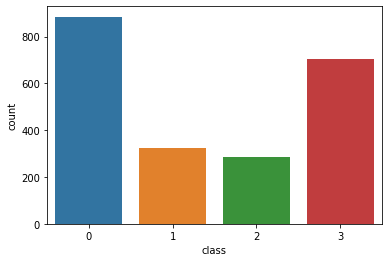

In [113]:
sns.countplot(df['class'],label="Count")

In [114]:
# How many people were children or adults?
df['age'].value_counts()

1    2092
0     109
Name: age, dtype: int64

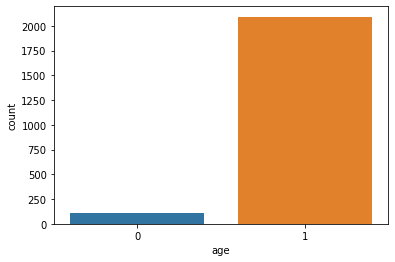

In [115]:
sns.countplot(df['age'],label="Count")

In [116]:
# How many people were male or female?
df['sex'].value_counts()

1    1731
0     470
Name: sex, dtype: int64

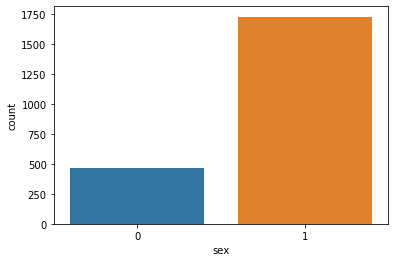

In [117]:
sns.countplot(df['sex'],label="Count")

In [118]:
# How many people survived?
df['survived'].value_counts()

0    1490
1     711
Name: survived, dtype: int64

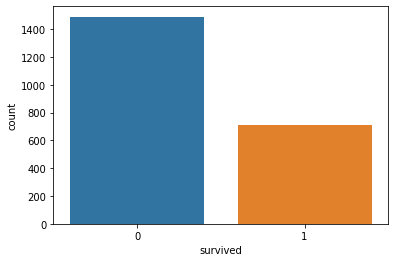

In [119]:
sns.countplot(df['survived'],label="Count")

### People Who Survived Baed On Attributes

In [120]:
# Average amount of people who survived in each class
df.groupby('class')[['survived']].mean()

,survived
class,
0,0.239548
1,0.624615
2,0.414035
3,0.252125


In [121]:
# Average amount of people who survived as a adult or child
df.groupby('age')[['survived']].mean()

,survived
age,
0,0.522936
1,0.312620


In [122]:
# # Average amount of people who survived as a male or female
df.groupby('sex')[['survived']].mean()

,survived
sex,
0,0.731915
1,0.212016


In [ ]:
# %load EvalMetrics.py
def TPos(y_test, y_pred):
    '''
    Upper left of the confusion matrix. 
    The statement is true and is positive.
    '''
    return sum((y_test == 1) and (y_pred == 1))

def TNeg(y_test, y_pred):
    '''
    Bottom right of the confusion matrix. 
    The statement is true and is negative.
    '''
    return sum((y_test == 0) and (y_pred == 0))

def FPos(y_test, y_pred):
    '''
    Bottom left of the confusion matrix. 
    The statement is false and is positive.
    '''
    return sum((y_test == 0) and (y_pred == 1))

def FNeg(y_test, y_pred):
    '''
    Upper right of the confusion matrix. 
    The statement is false and is negative.
    '''
    return sum((y_test == 1) and (y_pred == 0))

def C_Matrix(y_test, y_pred):
    '''
    Assigns variables to the matrix so we can
    calcualte evaulation metrics.
    '''
    TP = TPos(y_test,y_pred)
    FN = FNeg(y_test,y_pred)
    FP = FPos(y_test,y_pred)
    TN = TNeg(y_test,y_pred)
    return TP,FN,FP,TN

def accuracy(y_test, y_predict):
    '''
    Proportion of correct classifications out of 
    all the classifications available. 
    '''
    TP, FN, FP, TN = C_Matrix(y_test, y_predict) 
    
    correct = TP + TN 
    incorrect = TP + TN + FP + FN
        
    accuracy = correct / (correct + incorrect)
    return accuracy    
    
def precision(y_test, y_predict):
    '''
    This is the postive predictive value. It is the 
    proportion of correct postives out of all 
    classifed postivies.
    '''
    TP, FN, FP, TN = C_Matrix(y_test, y_predict)
    
    precision = TP / (TP + FP)
    return precision

def recall(y_test, y_predict):
    '''
    This is the true postive rate. It is the proportion
    of correcrly classifed postives out of all postivies. 
    '''
    TP, FN, FP, TN = C_Matrix(y_test, y_predict)

    recall = TP / (TP + FN)
    return recall

def F1_score(precision, recall):
    '''
    Summarizes a classifier in a singlen number. 
    '''
    F1_score = 2(precision * recall) / (precision + recall)
    return F1_score



In [ ]:
# %load ID3.py
def compute_entropy(class_probabilities):
    '''
    class_probabilities is a list of class probabilities
    '''
    terms = [-pi * np.log2(pi) for pi in class_probabilities if pi] # ignore zero probabilities
    H = np.sum(terms)
    return H

def compute_class_probabilities(instance_labels):
    '''
    instance_labels is a list of each examples' class label
    '''
    num_examples = len(instance_labels)
    counts = list(Counter(instance_labels).values())
    probabilities = np.array(counts) / num_examples
    return probabilities

def compute_subset_entropy(subset):
    '''
    subset is a list of instances as two-item tuples (attributes, label)
    '''
    labels = [label for _, label in subset]
    probabilities = compute_class_probabilities(labels)
    entropy = compute_entropy(probabilities)
    return entropy
    
def compute_partition_entropy(subsets):
    '''
    subsets is a list of class label lists
    '''
    num_examples = np.sum([len(s) for s in subsets])
    entropies = [(len(s) / num_examples) * compute_subset_entropy(s) for s in subsets]
    partition_entropy = np.sum(entropies)
    return partition_entropy

def partition_by(inputs, attribute):
    '''
    inputs is a list of tuple pairs: (attribute_dict, label)
    attribute is the proposed attribute to partition by
    returns a dictionary of attribute value: input subsets pairs
    '''
    subsets = {}
    for example in inputs:
        attribute_value = example[0][attribute]
        if attribute_value in subsets:
            subsets[attribute_value].append(example)
        else: # add this attribute_value to the dict
            subsets[attribute_value] = [example]
    return subsets

def partition_entropy_by(inputs, attribute):
    '''
    compute the partition
    compute the entropy of the partition
    '''
    subsets = partition_by(inputs, attribute)
    entropies = compute_partition_entropy(subsets.values())
    return entropies

def find_min_entropy_partition(inputs, attributes=None):
    '''
    Finds the partition with the minimum about of entropy.
    '''
    if attributes is None:
        attributes = list(inputs[0][0].keys())
    partition_entropies = []
    for attribute in attributes:
        partition_entropy = partition_entropy_by(inputs, attribute)
        print(attribute, partition_entropy)
        partition_entropies.append(partition_entropy)
    min_index = np.argmin(partition_entropies)
    return attributes[min_index]





        

In [ ]:
# %load DecisionTree.py
class Tree():
    tree = {}

    def decision_tree(self, inputs, attrb):
        '''
        Method that builds a tree using object oriented programming. 
        '''
        self.tree = build_tree(inputs, attrb, split_candidates = None)
        
def build_tree(inputs, attrb, split_candidates = None):
    '''
    implements the ID3 algorithm to build a decision tree
    '''
    if split_candidates is None:
        # this is the first pass
        split_candidates = list(inputs[0][0].keys())
        
    num_examples = len(inputs)
    # count Trues and Falses in the examples
    num_trues = len([label for attributes, label in inputs if label == True])
    num_falses = num_examples - num_trues
    
    # part (1) in the ID3 algorithm -> all same class label
    if num_trues == 0: # no trues, this is a False leaf node
        return False
    if num_falses == 0: # no falses, this is a True leaf node
        return True
    
    # part (2) in the ID3 algorithm -> list of attributes is empty -> leaf node with majority class label
    if not split_candidates: 
        return num_trues >= num_falses
    
    # part (3) in ID3 algorithm -> split on best attribute
    split_attribute = find_min_entropy_partition(inputs, split_candidates)
    partitions = partition_by(inputs, split_attribute)
    new_split_candidates = split_candidates[:]
    new_split_candidates.remove(split_attribute)
    
    # recursively build the subtrees
    subtrees = {}
    for attribute_value, subset in partitions.items():
        subtrees[attribute_value] = build_tree(subset, new_split_candidates)
        
    # missing (or unexpected) attribute value
    subtrees[None] = num_trues > num_falses
    
    return (split_attribute, subtrees)


In [ ]:
# %load KFold.py
def k_fold(clf, train_index, test_index, size):
    '''
    Examples are divied into test and
    train subsets and is iterated k 
    times until all the data is satisfied. 
    '''
    k_f = KFold(2201, n_splits = size, shuffle = False)
    outcomes = []
    
    for (train_index, test_index) in k_f:
        trainX, testX = train_X.values[train_index], train_X.values[test_index]
        trainY, testY = train_y.values[train_index], train_y.values[test_index]
        
        clf.fit(trainX, trainY)
        
        pred = clf.predict(testX)
        accur = accuracy(testY, pred)
        outcomes.append(accur)
        
    mean_outcome = np.mean(outcomes)
    return mean_outcome    





In [194]:
# Pass a list with length equal to the number of columns and drop list to test and train data

train_class = pd.get_dummies(df.class).drop('class', axis = 1)
test_class = pd.get_dummies(df.class).drop('class', axis = 1)

train_age = pd.get_dummies(df.age).drop('age', axis = 1)
test_age = pd.get_dummies(df.age).drop('age', axis = 1)

train_sex = pd.get_dummies(df.sex).drop('sex', axis = 1)
test_sex = pd.get_dummies(df.sex).drop('sex', axis = 1)

train_X = pd.concat([df['class'], train_age, train_sex], axis = 1)
test_X = pd.concat([df['class'], train_age, train_sex], axis = 1)

train_y = df['survived']

SyntaxError: invalid syntax (<ipython-input-194-38311decb379>, line 3)

In [198]:
# ID3 Code

clf = DecisionTree()

clf1 = clf.decision_tree(df, test_X)

accur_ID3 = k_fold(clf1, train_X, train_y, 20)
prec_ID3 =  k_fold(clf1, train_X, train_y, 20)
recall_ID3 = k_fold(clf1, train_X, train_yn, 20)
F1_ID3 = k_fold(clf1, train_X, train_y, 20)

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival']
)

AttributeError: 'DecisionTree' object has no attribute 'decision_tree'

In [199]:
# ID3 decision tree to sci-kit learn's implementation of a decision tree

X_train, X_test, y_train, y_test = train_test_split(X, y)

clf2 = tree.DecisionTreeClassifier()

print(X.shape, type(X))
print(y.shape, type(y))

clf2 = clf2.fit(X_train, y_train)
y_predict = clf2.predict(X_test)

accur_DTC = cross_val_score(clf2, X_train, y_train, cv = 20, scoring = 'accuracy')
prec_DTC = cross_val_score(clf2, X_train, y_train, cv = 20, scoring= 'precision')
recall_DTC = cross_val_score(clf2, X_train, y_train, cv = 20, scoring = 'recall')
F1_DTC = cross_val_score(clf2, X_train, y_train, cv = 20, scoring = 'f1')

print('\n')

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Not Survival', 'Predicted Survival'],
    index=['True Not Survival', 'True Survival']
)

(2201, 3) <class 'pandas.core.frame.DataFrame'>
(2201,) <class 'pandas.core.series.Series'>




,Predicted Not Survival,Predicted Survival
True Not Survival,345,13
True Survival,121,72


In [200]:
print('Accuracy', accur_ID3)
print('Precision', prec_ID3)
print('Recall',recall_ID3)
print('F1 Score', F1_ID3)

Accuracy 0.8003629764065335
Precision 0.95
Recall 0.4175824175824176


NameError: name 'F1_ID3' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

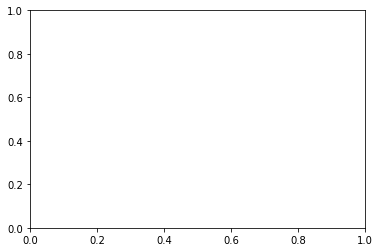

In [201]:
#ID3

x1 = range(0,20)
y1 = accur_ID3
plt.plot(x1, y1, label = "Accuracy") 

x2 = range(0, 20)
y2 = prec_ID3
plt.plot(x2, y2, label = "Precision") 

x3 = range(0, 20)
y3 = recall_ID3
plt.plot(x3, y3, label = "Recall") 

x4 = range(0, 20)
y4 = F1_ID3
plt.plot(x4, y4, label = "F1 Score") 

plt.xlabel('K') 
plt.ylabel('Evaluation Metrics') 
plt.title('ID3 Graph')
plt.legend() 

plt.show() 

In [202]:
print('Accuracy', accur_DTC)
print('Precision', prec_DTC)
print('Recall',recall_DTC)
print('F1 Score', F1_DTC)

Accuracy [0.79518072 0.84337349 0.80722892 0.80722892 0.75903614 0.78313253
 0.77108434 0.74698795 0.75903614 0.86746988 0.8313253  0.80722892
 0.76829268 0.74390244 0.75609756 0.76829268 0.7804878  0.81707317
 0.87654321 0.81481481]
Precision [1.         0.88235294 0.91666667 1.         0.6875     0.83333333
 0.81818182 1.         0.71428571 0.94117647 1.         0.91666667
 0.88888889 1.         1.         1.         0.9        0.92307692
 0.94117647 1.        ]
Recall [0.34615385 0.57692308 0.42307692 0.38461538 0.42307692 0.38461538
 0.34615385 0.19230769 0.38461538 0.61538462 0.46153846 0.42307692
 0.30769231 0.19230769 0.23076923 0.26923077 0.34615385 0.46153846
 0.64       0.4       ]
F1 Score [0.51428571 0.69767442 0.57894737 0.55555556 0.52380952 0.52631579
 0.48648649 0.32258065 0.5        0.74418605 0.63157895 0.57894737
 0.45714286 0.32258065 0.375      0.42424242 0.5        0.61538462
 0.76190476 0.57142857]


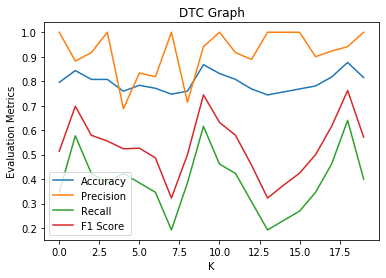

In [203]:
#DTC

x1 = range(0,20)
y1 = accur_DTC
plt.plot(x1, y1, label = "Accuracy") 

x2 = range(0, 20)
y2 = prec_DTC
plt.plot(x2, y2, label = "Precision") 

x3 = range(0, 20)
y3 = recall_DTC
plt.plot(x3, y3, label = "Recall") 

x4 = range(0, 20)
y4 = F1_DTC
plt.plot(x4, y4, label = "F1 Score") 

plt.xlabel('K') 
plt.ylabel('Evaluation Metrics') 
plt.title('DTC Graph')
plt.legend() 

plt.show() 

#### Observing The Plots

What do you notice?
* The higher the evalutation metric is on the graph, the more reliable it will be for measurement purposes. 

How does K impact each of the evaluation metrics?
* For accuracy, as K increases, the accuracy fluxuates up and down. There is no steady trend when determining the accuracy. 
* For precision, as K increases, the precision stays the same. 
* For recall, as K increases, there is either a big increase or decrease in the trend.  
* For F1 score, just like recall, as K increases, there is a big increase or decrease. The difference is that this has a higher measurement than the recall. 

How does the different tree implementation affect the performance?
* The ID3 implementation affects the perfomance because since it is choosing the next immediate best option, it is not looking at the overall structure of the tree. 
* The Decision Tree Classification implementation affects the perfomace because it can grow to deep and not know when to stop, or missing attributes when handling training attributes.